In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [96]:
# Set the start and end dates for fetching data
end = datetime.now()
start = datetime(end.year - 20, end.month, end.day)

# Choose the default stock symbol
default_stock = 'AAPL'

# Download stock data
data = yf.download(default_stock, start, end, auto_adjust=True)

[*********************100%%**********************]  1 of 1 completed


## Knowing about data (We use AAPL for example)

In [97]:
# Summary Stats
data.describe()

,Open,High,Low,Close,Volume
count,5035.000000,5035.000000,5035.000000,5035.000000,5.035000e+03
mean,44.137870,44.611029,43.684065,44.167840,4.016651e+08
std,55.487841,56.084830,54.933214,55.537494,3.978199e+08
min,0.392610,0.398053,0.385354,0.389738,2.404830e+07
25%,5.278397,5.354440,5.181793,5.255267,1.083100e+08
50%,20.171511,20.329104,19.919773,20.124443,2.617384e+08
75%,49.531137,50.001380,49.198518,49.633423,5.719630e+08
max,197.767647,199.365599,196.748941,197.857529,3.372970e+09


In [98]:
data.info

<bound method DataFrame.info of                   Open        High         Low       Close     Volume
Date                                                                 
2004-04-27    0.411810    0.414834    0.403495    0.407274  283864000
2004-04-28    0.405461    0.408333    0.398204    0.399867  231168000
2004-04-29    0.399867    0.408182    0.392762    0.404705  460790400
2004-04-30    0.403798    0.407578    0.385354    0.389738  466502400
2004-05-03    0.393064    0.398053    0.389133    0.394122  297634400
...                ...         ...         ...         ...        ...
2024-04-22  165.520004  167.259995  164.770004  165.839996   48116400
2024-04-23  165.350006  167.050003  164.919998  166.899994   49537800
2024-04-24  166.539993  169.300003  166.210007  169.020004   48251800
2024-04-25  169.529999  170.610001  168.149994  169.889999   50558300
2024-04-26  169.880005  171.339996  169.179993  169.300003   44525100

[5035 rows x 5 columns]>

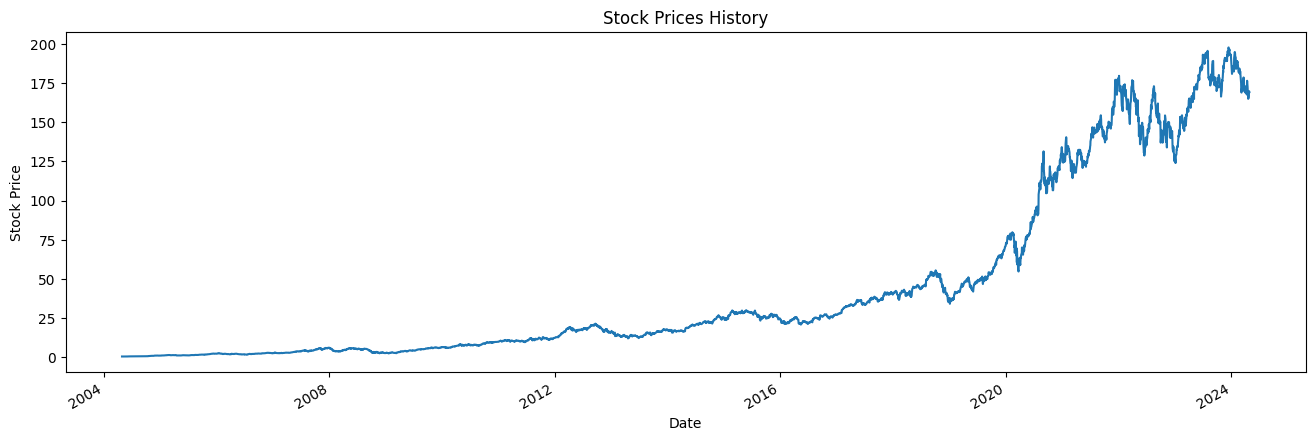

In [99]:
plt.figure(figsize=(16, 5))
data['Close'].plot()
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Prices History")
plt.show()

In [100]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2004-04-27,0.411810,0.414834,0.403495,0.407274,283864000
2004-04-28,0.405461,0.408333,0.398204,0.399867,231168000
2004-04-29,0.399867,0.408182,0.392762,0.404705,460790400
2004-04-30,0.403798,0.407578,0.385354,0.389738,466502400
2004-05-03,0.393064,0.398053,0.389133,0.394122,297634400
...,...,...,...,...,...
2024-04-22,165.520004,167.259995,164.770004,165.839996,48116400
2024-04-23,165.350006,167.050003,164.919998,166.899994,49537800
2024-04-24,166.539993,169.300003,166.210007,169.020004,48251800


In [101]:
data.shape

(5035, 5)

In [102]:
# To reset the index
data.reset_index(inplace=True)
data.dropna(inplace=True)

In [103]:
data.shape

(5035, 6)

In [104]:
data

,Date,Open,High,Low,Close,Volume
0,2004-04-27,0.411810,0.414834,0.403495,0.407274,283864000
1,2004-04-28,0.405461,0.408333,0.398204,0.399867,231168000
2,2004-04-29,0.399867,0.408182,0.392762,0.404705,460790400
3,2004-04-30,0.403798,0.407578,0.385354,0.389738,466502400
4,2004-05-03,0.393064,0.398053,0.389133,0.394122,297634400
...,...,...,...,...,...,...
5030,2024-04-22,165.520004,167.259995,164.770004,165.839996,48116400
5031,2024-04-23,165.350006,167.050003,164.919998,166.899994,49537800
5032,2024-04-24,166.539993,169.300003,166.210007,169.020004,48251800
5033,2024-04-25,169.529999,170.610001,168.149994,169.889999,50558300


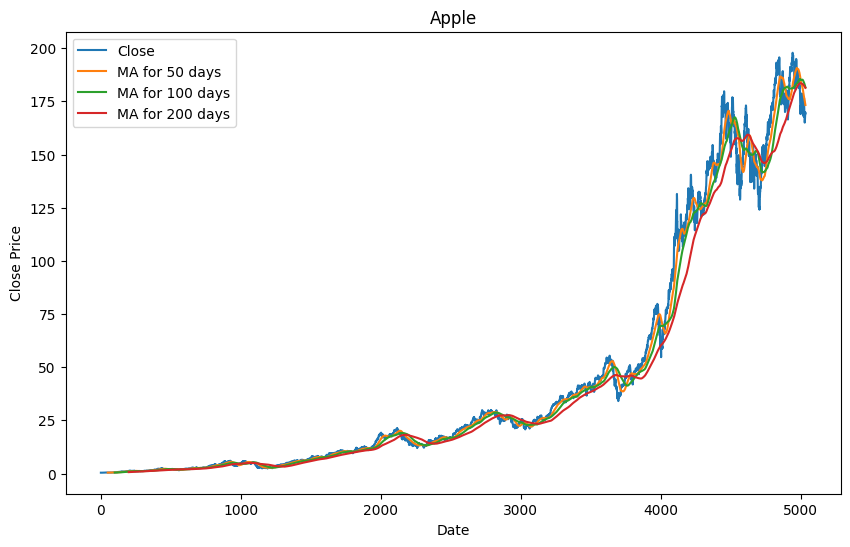

In [105]:
ma_day = [50, 100, 200]

fig, ax = plt.subplots(figsize=(10, 6))  # Create a single subplot

for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(ma).mean()

# Plot the Close price and moving averages on the same subplot
data[['Close', 'MA for 50 days', 'MA for 100 days', 'MA for 200 days']].plot(ax=ax)

ax.set_title('Apple')  # Set the title for the subplot
ax.legend()  # Show legend for the plot
ax.set_ylabel('Close Price')
ax.set_xlabel('Date')

plt.show()


In [106]:
# Convert 'Close' column to numpy array
data_set = data['Close'].values.reshape(-1, 1)

In [107]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_set_scaled = scaler.fit_transform(data_set)

## Prepare the training data

In [108]:
def prepare_training_data(data, window, horizon):
    x_train = []
    y_train = []
    for i in range(window, len(data) - horizon + 1):
        x_train.append(data[i - window:i, 0])
        y_train.append(data[i:i + horizon, 0])  # Predict the next 'horizon' time steps
    return np.array(x_train), np.array(y_train)

In [109]:
# Prepare data for LSTM
window_size = 100
horizon = 30  # Predict the next 30 days
x_train, y_train = prepare_training_data(data_set_scaled, window_size, horizon)

# Reshape input data for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Build the LSTM model

In [110]:
model = Sequential([
    LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(units=128, return_sequences=True),
    Dropout(0.3),
    LSTM(units=128),
    Dropout(0.3),
    Dense(units=horizon)  # Predict the next 'horizon' time steps
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 240ms/step - loss: 0.0380
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 18s 238ms/step - loss: 0.0050
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 18s 239ms/step - loss: 0.0035
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 18s 233ms/step - loss: 0.0030
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 18s 235ms/step - loss: 0.0031
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 18s 235ms/step - loss: 0.0021
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 240ms/step - loss: 0.0023
Epoch 8/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 240ms/step - loss: 0.0021
Epoch 9/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 242ms/step - loss: 0.0019
Epoch 10/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 244ms/step - loss: 0.0019
Epoch 11/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 18s 236ms/step - loss: 0.0019
Epoch 12/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 240ms/step - loss: 0.0017
Epoch 13/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 18s 237ms/step - loss: 0.0016
Epoch 14/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 18s 239ms/step - loss: 0.0017
Epoch 15/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1

In [111]:
# Update the prepare_test_data function for future predictions
def prepare_test_data(data, window):
    x_test = data[-window:].reshape(1, -1, 1)  # Use the last 'window' days' closing price as input
    return x_test

# Prepare test data
x_test = prepare_test_data(data_set_scaled, window_size)

In [112]:
# Predict future stock prices using the LSTM model
future_predictions_lstm = []
x_future_lstm = x_test.copy()
for i in range(horizon):  # Predict the next 'horizon' time steps
    prediction = model.predict(x_future_lstm)[:, -1]  # Predict the next value
    future_predictions_lstm.append(prediction)
    x_future_lstm = np.concatenate([x_future_lstm[:, 1:, :], prediction.reshape(1, 1, 1)], axis=1)  # Update input for the next prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

In [113]:
# Inverse scaling to get actual prices
future_predictions_lstm = scaler.inverse_transform(np.array(future_predictions_lstm).reshape(-1, 1))

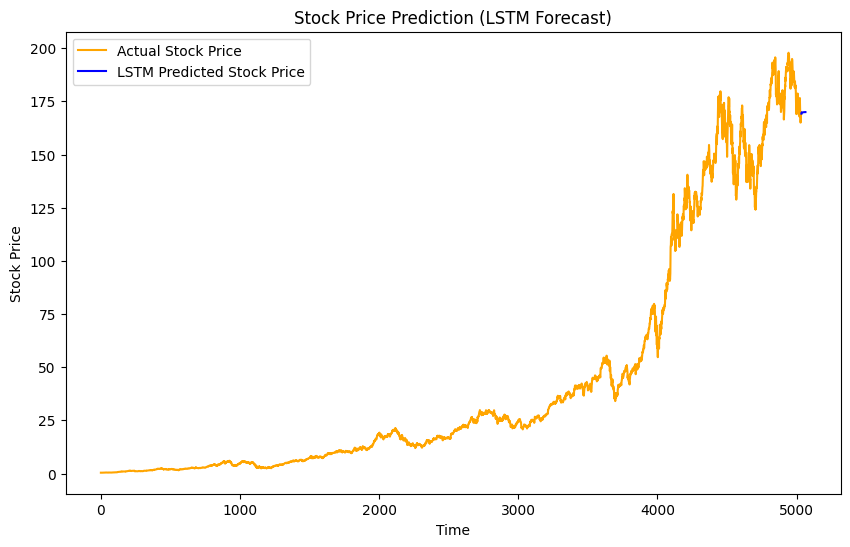

In [114]:
# Plot the true values, LSTM predictions, and future forecast
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], color='orange', label='Actual Stock Price')
plt.plot(range(len(data['Close']), len(data['Close']) + horizon), future_predictions_lstm, color='blue', label='LSTM Predicted Stock Price')
plt.title('Stock Price Prediction (LSTM Forecast)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [115]:
# Evaluate the LSTM forecast
true_future_prices = data['Close'].values[-horizon:]  # True future prices for comparison
mse_lstm = mean_squared_error(true_future_prices, future_predictions_lstm)
mae_lstm = mean_absolute_error(true_future_prices, future_predictions_lstm)

print("Mean Squared Error (LSTM Forecast):", mse_lstm)
print("Mean Absolute Error (LSTM Forecast):", mae_lstm)

Mean Squared Error (LSTM Forecast): 10.73383988989517
Mean Absolute Error (LSTM Forecast): 2.4339284261067706


## As we can see the future pridiction then the second model will show about LSTM that is predict the past value

Epoch 1/100


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 30s 182ms/step - loss: 0.0129
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 29s 184ms/step - loss: 0.0014
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 29s 185ms/step - loss: 0.0012
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 28s 183ms/step - loss: 0.0014
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 28s 183ms/step - loss: 0.0012
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 28s 183ms/step - loss: 9.7665e-04
Epoch 7/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 29s 186ms/step - loss: 8.0708e-04
Epoch 8/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 29s 187ms/step - loss: 9.5453e-04
Epoch 9/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 29s 186ms/step - loss: 9.3807e-04
Epoch 10/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 28s 180ms/step - loss: 0.0011
Epoch 11/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 28s 180ms/step - loss: 7.5749e-04
Epoch 12/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 28s 178ms/step - loss: 0.0011
Epoch 13/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 27s 177ms/step - loss: 0.0010
Epoch 14/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 28s 178ms/step - loss: 

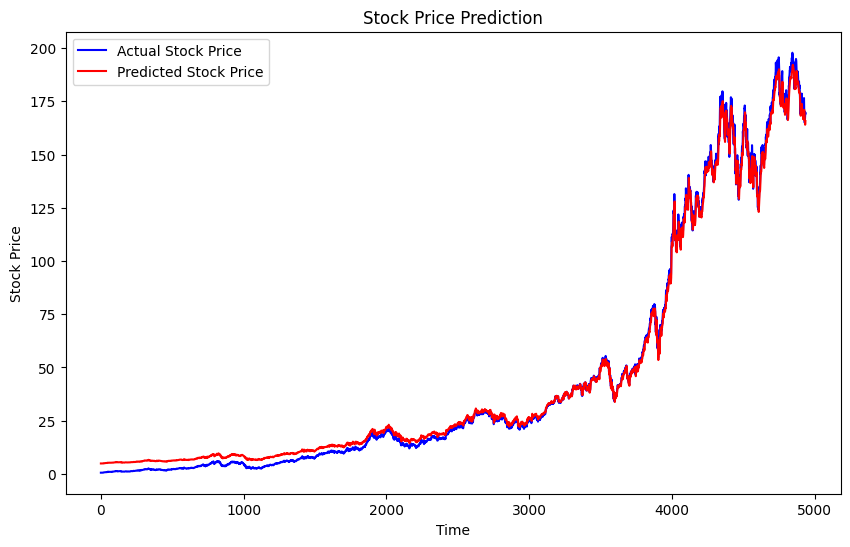

Mean Squared Error: 9.104012287371622
Mean Absolute Error: 2.5555254086172687


In [116]:
# Prepare the training data for the second model
def prepare_training_data(data, window):
    x_train = []
    y_train = []
    for i in range(window, len(data)):
        x_train.append(data[i-window:i, 0])
        y_train.append(data[i, 0])
    return np.array(x_train), np.array(y_train)

# Prepare data for the second model
window_size = 100
x_train, y_train = prepare_training_data(data_set_scaled, window_size)

# Reshape input data for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the second LSTM model
model = Sequential([
    LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(units=128, return_sequences=True),
    Dropout(0.3),
    LSTM(units=128),
    Dropout(0.3),
    Dense(units=1)
])

# Compile the second model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the second model
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=1)

# Prepare test data for the second model
def prepare_test_data(data, window):
    x_test = []
    y_test = []
    for i in range(window, len(data)):
        x_test.append(data[i-window:i, 0])
        y_test.append(data[i, 0])
    return np.array(x_test), np.array(y_test)

# Prepare test data for the second model
x_test, y_test = prepare_test_data(data_set_scaled, window_size)

# Reshape input data for LSTM
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Predict on test data for the second model
y_predict = model.predict(x_test)

# Inverse scaling to get actual prices
y_predict = scaler.inverse_transform(y_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the true values and predicted values for the second model
plt.figure(figsize=(10, 6))
plt.plot(y_test, color='blue', label='Actual Stock Price')
plt.plot(y_predict, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Evaluate the second model
mse = mean_squared_error(y_test, y_predict)
mae = mean_absolute_error(y_test, y_predict)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

## Next we will show the predict future stock prices for the second model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

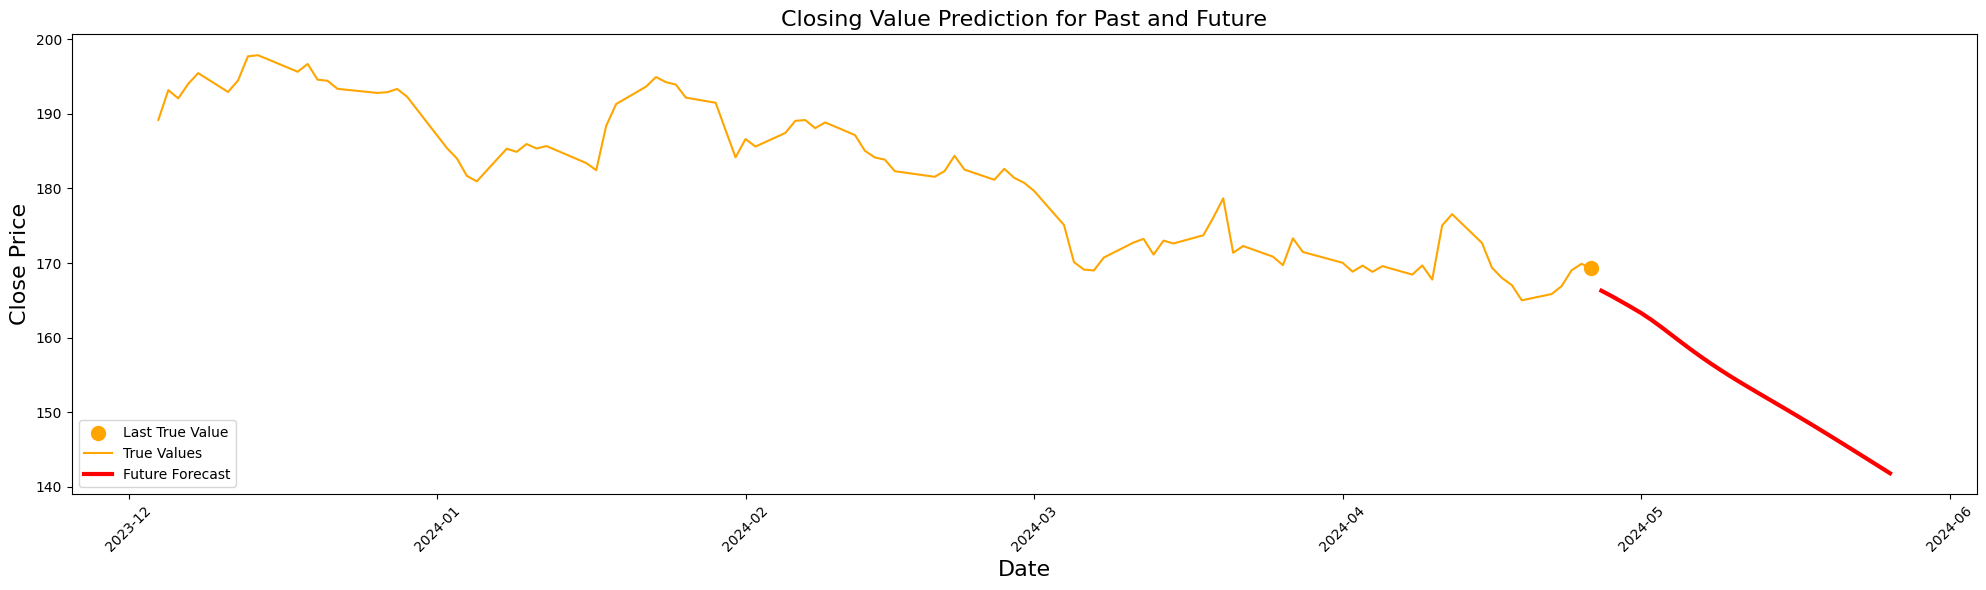

In [117]:
# Predict future stock prices for the second model
x_future = data_set_scaled[-window_size:].reshape(1, -1, 1)  # Use the last 100 data points for prediction
future_predictions = []
for i in range(30):  # Predict the next 30 days
    prediction = model.predict(x_future)  # Predict the next value
    future_predictions.append(prediction[0, 0])  # Append the predicted value to future_predictions
    x_future = np.concatenate([x_future[:, 1:, :], prediction.reshape(1, 1, 1)], axis=1)  # Update input for the next prediction

# Inverse scaling to get actual prices
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate list of future dates
future_dates = pd.date_range(start=data['Date'].iloc[-1] + pd.DateOffset(days=1), periods=30)

# Extract recent dates (assuming you want the last 100 days)
recent_dates = data['Date'].iloc[-window_size:]

# Extract last true value (assuming 'Close' is the closing price column)
last_true_value = data['Close'].iloc[-1]

# Plot the true values, predictions, and future forecast for the second model
plt.figure(figsize=(20, 6))
plt.scatter(recent_dates.iloc[-1], last_true_value, marker='o', s=100, c='orange', label='Last True Value')
plt.plot(recent_dates, data['Close'].iloc[-window_size:], c='orange', label='True Values')
plt.plot(future_dates, future_predictions, lw=3, c='r', linestyle='-', label='Future Forecast')
plt.legend(loc="lower left")
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close Price", fontsize=16)
plt.title("Closing Value Prediction for Past and Future", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## The first model predicts sequences of future stock prices for multiple days ahead, while the second model predicts single stock prices for the next day.We can choose what to refer for the prediction

## Can we improve the model more? Yes! wecan try a Naive Forecast.

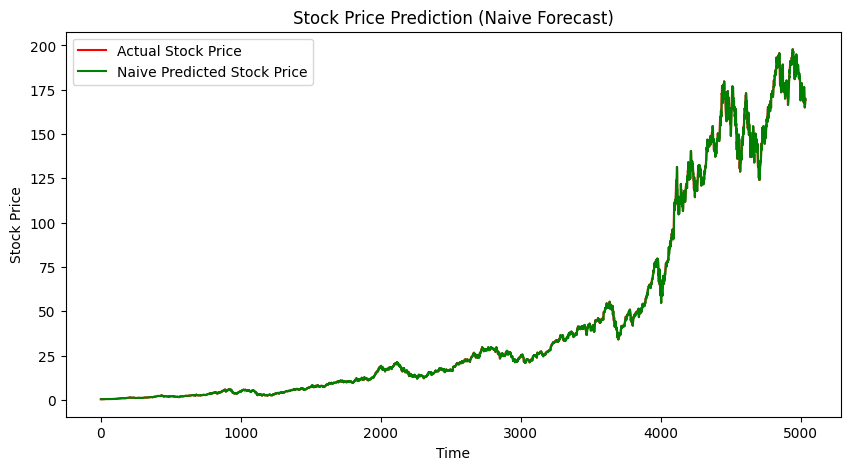

Mean Squared Error (Naive Forecast): 1.560214953173422
Mean Absolute Error (Naive Forecast): 0.5770462192935417


In [120]:
# Create a column for the next day's closing price
data['NextClose'] = data['Close'].shift(-1)

# Prepare the test data for prediction
def prepare_test_data(data):
    x_test = data['Close'].values[:-1]  # Using all but the last day's closing price
    y_test = data['NextClose'].values[:-1]
    return x_test, y_test

# Prepare test data
x_test, y_test = prepare_test_data(data)

# Predict tomorrow's closing price as today's closing price
y_predict_naive = x_test

# Plot the true values and predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test, color='red', label='Actual Stock Price')
plt.plot(y_predict_naive, color='green', label='Naive Predicted Stock Price')
plt.title('Stock Price Prediction (Naive Forecast)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Evaluate the model
mse_naive = mean_squared_error(y_test, y_predict_naive)
mae_naive = mean_absolute_error(y_test, y_predict_naive)

print("Mean Squared Error (Naive Forecast):", mse_naive)
print("Mean Absolute Error (Naive Forecast):", mae_naive)

## Showing that from naive forecast formula is not for predict more than 1 more next day.

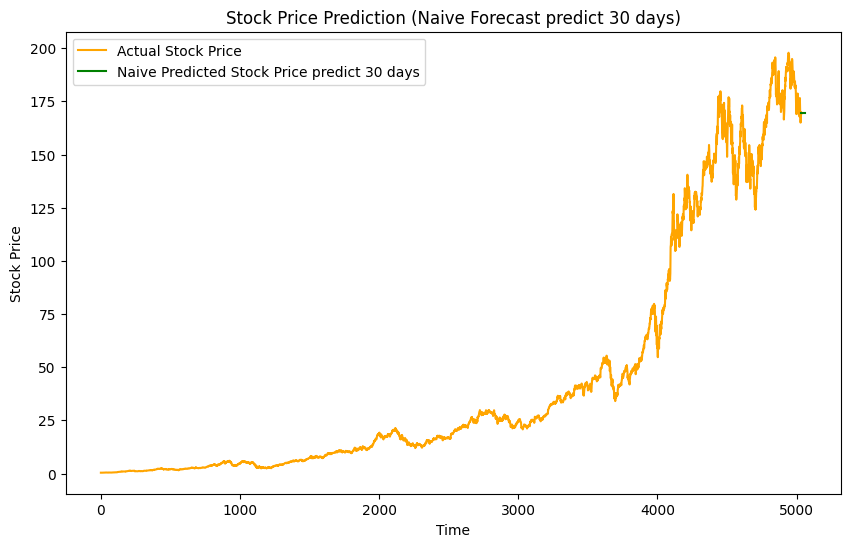

Mean Squared Error (Naive Forecast predict 30 days): 11.523071916533324
Mean Absolute Error (Naive Forecast predict 30 days): 2.4393325805664063


In [119]:
# Prepare the test data for prediction
def prepare_test_data(data, window):
    x_test = data['Close'].values[-window:]  # Using the last 'window' days' closing price
    return x_test

# Prepare test data
x_test = prepare_test_data(data, window_size)

# Predict future stock prices using naive forecast
future_predictions_naive = []
last_price = x_test[-1]  # Last available price
for i in range(30):  # Predict the next 30 days
    future_predictions_naive.append(last_price)  # Append the last available price
    # Update the last available price for the next prediction
    last_price = future_predictions_naive[-1]

# Plot the true values, naive predictions, and future forecast
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], color='orange', label='Actual Stock Price')
plt.plot(range(len(data['Close']), len(data['Close']) + len(future_predictions_naive)), future_predictions_naive, color='green', label='Naive Predicted Stock Price predict 30 days')
plt.title('Stock Price Prediction (Naive Forecast predict 30 days)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Evaluate the improved naive forecast
# Calculate the true future prices for comparison
true_future_prices = data['Close'].values[-30:]

# Calculate mean squared error and mean absolute error
mse_naive = mean_squared_error(true_future_prices, future_predictions_naive)
mae_naive = mean_absolute_error(true_future_prices, future_predictions_naive)

print("Mean Squared Error (Naive Forecast predict 30 days):", mse_naive)
print("Mean Absolute Error (Naive Forecast predict 30 days):", mae_naive)

## From the Naive Forecast the is show it is better to forcast the next days but not predict the long future trend! 
## For long trend we can use LSTM model but it is not accurate much for risking on buying!